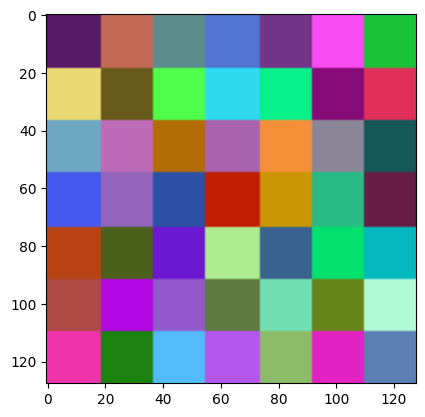

In [23]:
# image mapping
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt

src = np.random.randint(0,256,(7,7,3),dtype=np.uint8)
src = cv2.resize(src,(128,128),interpolation=cv2.INTER_NEAREST)
plt.imshow(src)

In [38]:
def get_inv_FCG_mapping(nr,pmax,p0,c_gaze, dtype=np.int32):
    """
    Returns inverse mapping of Foveal Cartesian Geometry.
    This inverse mapping is required for the cv2::remap to perform foveation
    
    Parameters
    nr : Integer
        Number of rings, not including fovea. nr > 0.
    pmax : Integer
        Maximum distance where the last ring should be positioned. Pixel unit. pmax > p0.
    p0 : Integer
        Fovea radius. Pixel Unit. p0 > 0
    c_gaze : (Integer, Integer)
        In (x0, y0) shape. Center point of gaze in src image.
    dtype : str or dtype
        Typecode or data-type to which the returned arrays are cast. default np.int32
        
    Returns
        X, Y : ndarray
        inverse mapping X and Y. arrays are the same size with the foveated image.
    """
    # factor a
    a = math.exp(1/nr*math.log(pmax/p0))
    # Delta p(Xi)
    delta_p = lambda xi: (p0*a**xi)/(p0+xi) # xi = 1,2,...,Nr
    x0, y0 = c_gaze
    # center point of foveated image
    fcx = fcy = p0+nr
    # get meshgrid of x' and y' to use np
    dx = np.arange(0,(p0+nr)*2+1)
    dy = np.arange(0,(p0+nr)*2+1)
    X_out, Y_out = np.meshgrid(dx,dy) # _out is equal to ' in Table 1.
    # inverse mapping algorithm as in Table 1.
    X_out = X_out - fcx
    Y_out = Y_out - fcy
    R = np.max(np.stack((np.abs(X_out),np.abs(Y_out))),axis=0)
    # In the paper, case where r <= p0 is defined separately.
    # However, it is not necessary if XI = 0 for XI < 0
    XI = np.clip(R-p0,0,nr)
    X = np.floor(X_out*delta_p(XI)+x0).astype(dtype)
    Y = np.floor(Y_out*delta_p(XI)+y0).astype(dtype)
    return X,Y

def get_FCG_mapping(nr,pmax,p0,c_gaze,src_size,dtype=np.int32):
    """
    Returns the mapping of Foveal Cartesian Geometry.
    This mapping is required for the cv2::remap to perform recovery from foveated image
    
    Parameters
    nr : Integer
        Number of rings, not including fovea. nr > 0.
    pmax : Integer
        Maximum distance where the last ring should be positioned. Pixel unit. pmax > p0.
    p0 : Integer
        Fovea radius. Pixel Unit. p0 > 0
    c_gaze : (Integer, Integer)
        In (x0, y0) shape. Center point of gaze in src image.
    src_size : (Integer,Integer)
        (height, width) of the src image.
    dtype : str or dtype
        Typecode or data-type to which the returned arrays are cast. default np.int32
        
    Returns
        X_out, Y_out : ndarray
        The mapping X and Y. arrays are the same size with the src image.
    """
    # factor a
    a = math.exp(1/nr*math.log(pmax/p0))
    # Delta p(Xi)
    delta_p = lambda xi: (p0*a**xi)/(p0+xi) # xi = 1,2,...,Nr
    x0, y0 = c_gaze
    h, w = src_size
    # center point of foveated image
    fcx = fcy = p0+nr
    # get meshgrid of x and y to use np
    dx = np.arange(0,w)
    dy = np.arange(0,h)
    X, Y = np.meshgrid(dx,dy)
    # mapping algorithm as in Table 1.
    X = X-x0
    Y = Y-y0
    # distance map
    P = np.max(np.stack((np.abs(X),np.abs(Y))),axis=0)
    # if-else clause can be defined simultaneously if 
    # (p = p0 for p <= p0) and (p = pmax for p >= pmax)
    P = np.clip(P,p0,pmax)
    XI = np.floor(np.log(P/p0)/np.log(a))
    X_out = np.floor(X/delta_p(XI)+fcx).astype(dtype)
    Y_out = np.floor(Y/delta_p(XI)+fcy).astype(dtype)
    return X_out, Y_out

In [20]:
def batch_remap(src, X, Y, borderValue=0):
    """
    cv2.remap like operation using numpy indexing.
    Remap implementation for batch operation
    
    Parameters
    src : np.ndarray
        source batch. Expected to be (B,C,H,W)
    X : Integer ndarray
        X mapping.
    Y : Integer ndarray
        Y mapping.
    borderValue : Integer
        border fill. TODO) also allow per channel value
    """
    b,c,h,w = src.shape
    # separate mappings that are outside the src image border
    X_b = (X < 0) + (X >= src.shape[3])
    X_in = X*(1-X_b)
    Y_b = (Y < 0) + (Y >= src.shape[2])
    Y_in = Y*(1-Y_b)
    
    dst = src[:,:,Y_in.flatten(),X_in.flatten()].reshape((b,c,*X.shape))
    print(dst.shape)
    XY_b = np.logical_or(X_b,Y_b)
    dst = dst*(1-XY_b) + borderValue*XY_b
    
    return dst

(3, 1, 128, 128)
(3, 1, 61, 61)
(3, 1, 61, 61)


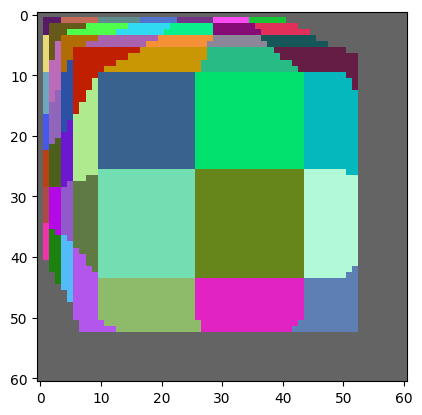

In [53]:
X, Y = get_inv_FCG_mapping(nr=10,pmax=100,p0=20,c_gaze=(96,96))

h,w,c = src.shape
b_src = np.transpose(src,(2,0,1)).reshape((c,1,h,w))
print(b_src.shape)

b_fov = batch_remap(b_src,X,Y,borderValue=100)
print(b_fov.shape)

# transpose fov for viz
fov_viz = np.transpose(b_fov.reshape((3,*b_fov.shape[2:])),(1,2,0))
plt.imshow(fov_viz)

(3, 1, 128, 128)
(3, 1, 128, 128)


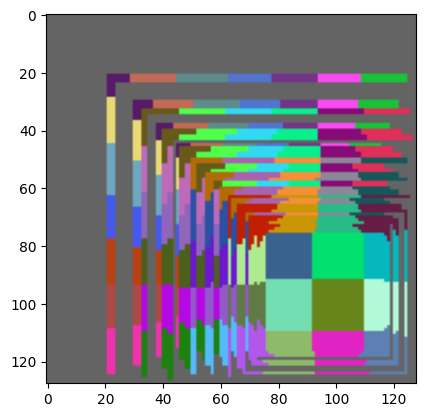

In [54]:
X_out, Y_out = get_FCG_mapping(nr=10,pmax=100,p0=20,c_gaze=(96,96),
                               src_size=src.shape[:2],dtype=np.int32)

b_recov = batch_remap(b_fov,X_out,Y_out,borderValue=100)
print(b_recov.shape)

# transpose fov for viz
b_recov_viz = np.transpose(b_recov.reshape((3,*b_recov.shape[2:])),(1,2,0))
plt.imshow(b_recov_viz)

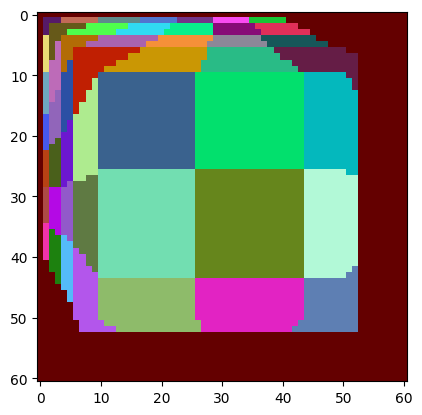

In [55]:
X, Y = get_inv_FCG_mapping(nr=10,pmax=100,p0=20,c_gaze=(96,96),
                           dtype=np.float32)
fov = cv2.remap(src,X,Y,
               interpolation=cv2.INTER_NEAREST,
               borderMode=cv2.BORDER_CONSTANT, borderValue=100)
plt.imshow(fov)

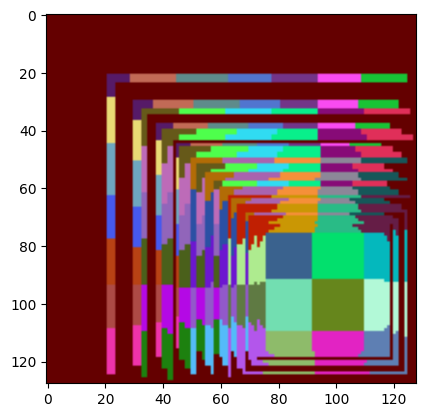

In [56]:
X_out, Y_out = get_FCG_mapping(nr=10,pmax=100,p0=20,c_gaze=(96,96),
                               src_size=src.shape[:2],dtype=np.float32)
recov = cv2.remap(fov,X_out,Y_out,
               interpolation=cv2.INTER_AREA,
               borderMode=cv2.BORDER_CONSTANT, borderValue=100)
plt.imshow(recov)